## Preparing existing models for the ensemble challenge

In [1]:
import copy
import os
import glob
import pandas as pd
import tqdm
from collections import defaultdict
import pystow
from mira.sources.sbml import template_model_from_sbml_file
from mira.metamodel import Concept, NaturalConversion, Parameter, Observable, Distribution, model_to_json_file
from mira.metamodel.search import find_models_with_grounding
from mira.metamodel.comparison import get_dkg_refinement_closure
from mira.modeling import Model
from mira.modeling.petri import PetriNetModel
from mira.metamodel.ops import simplify_rate_laws

### Explore BioModels and find relevant models

In [2]:
base_folder = pystow.join('mira', 'biomodels', 'models')
fnames = sorted(glob.glob(os.path.join(base_folder.as_posix(),
                                       'BIOMD*/BIOMD*.xml')))
models = {}
for fname in tqdm.tqdm(fnames):
    model_id = os.path.splitext(os.path.basename(fname))[0]
    models[model_id] = template_model_from_sbml_file(fname)

 21%|██████████████▊                                                       | 7/33 [00:09<00:24,  1.08it/s]

unhandled model_type: ncit:C71292
unhandled model_type: ido:0000503
unhandled model_type: ido:0000503


100%|█████████████████████████████████████████████████████████████████████| 33/33 [00:10<00:00,  3.21it/s]


In [3]:
groundings = {
    'hospitalization': 'ncit:C25179',
    'death': 'ncit:C28554',
    'detected': 'ncit:C15220',
    'infected': 'ido:0000511',
}

In [4]:
models_for_grounding = defaultdict(set)
for grounding, curie in groundings.items():
    db, id = curie.split(':')
    models_for_grounding[grounding] = set(find_models_with_grounding(models, db, id))
models_for_grounding = dict(models_for_grounding)

In [5]:
# Create a DataFrame with one row for each model file and one column for each term
df = pd.DataFrame(index=sorted(set(models)), columns=models_for_grounding.keys())

# Fill the DataFrame with boolean values indicating whether each model file is associated with each term
for term, models_ in models_for_grounding.items():
    for model in models_:
        df.loc[model, term] = True

df.fillna(False, inplace=True)  # Fill missing values with False

# Reset the index to make the model file paths a regular column
df = df.reset_index().rename(columns={'index': 'model'})

In [6]:
df

,model,hospitalization,death,detected,infected
0,BIOMD0000000249,False,False,False,False
1,BIOMD0000000294,False,False,False,False
2,BIOMD0000000715,False,False,False,True
3,BIOMD0000000716,False,False,False,True
4,BIOMD0000000717,False,False,False,True
5,BIOMD0000000726,False,False,False,True
6,BIOMD0000000949,False,False,False,False
7,BIOMD0000000950,False,False,False,False
8,BIOMD0000000955,False,True,True,True
9,BIOMD0000000956,False,False,False,True


### Adding some extra information to models

In [9]:
from mira.modeling.viz import *

In [10]:
def add_distribution(p):
    if p.value == 0:
        return
    else:
        p.distribution = Distribution(
            type='StandardUniform1',
            parameters={
                'minimum': p.value-0.2*abs(p.value),
                'maximum': p.value+0.2*abs(p.value),
            }
        )

In [11]:
cases = Concept(name='Cases',
                identifiers={'ido': '0000511'},
                context={'diagnosed': 'ncit:C113725'})
hospitalizations = Concept(name='Hospitalizations',
                           identifiers={'ido': '0000511'},
                           context={'hospitalization': 'ncit:C25179'})
deaths = Concept(name='Deaths',
                 identifiers={'ncit': 'C28554'})

## Zong et al model

In [12]:
model = copy.deepcopy(models['BIOMD0000000983'])
model = simplify_rate_laws(model)

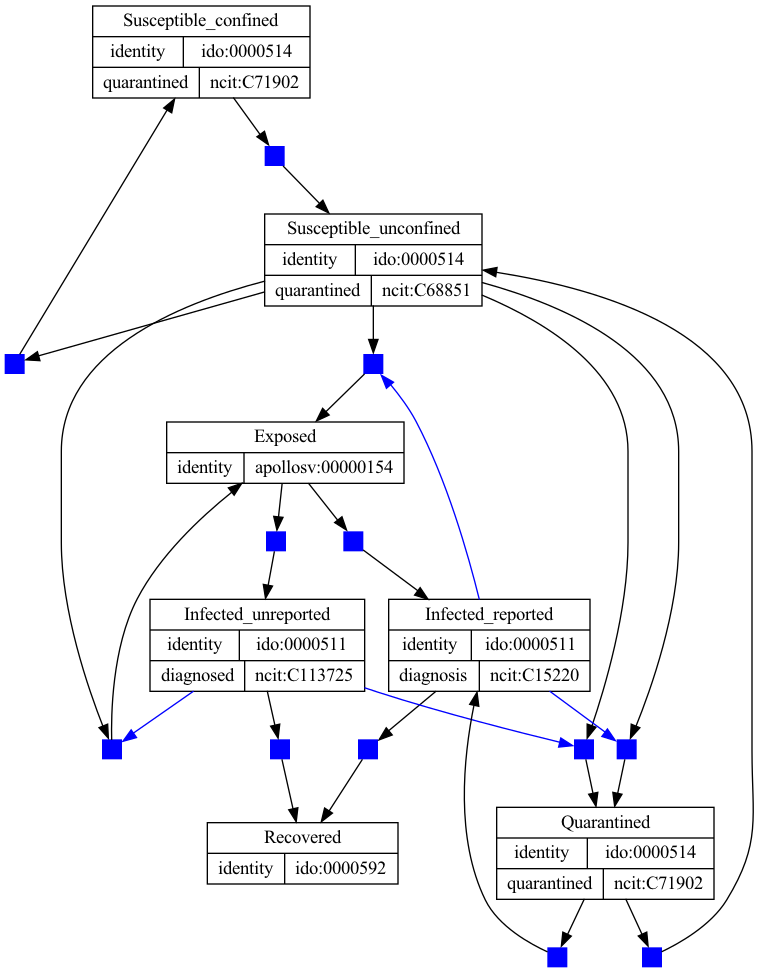

In [13]:
GraphicalModel.for_jupyter(model, width='50%')

Observables:
- Cases: Infected_reported
- Deaths: --> extend model
- Hospitalization: param*infected_reported

In [14]:
from sympy import Symbol
t = NaturalConversion(
        subject=Concept(name='Infected_reported', identifiers={'ido': '0000511'}, context={'diagnosis': 'ncit:C15220'}),
        outcome=Concept(name='Deceased', identifiers={'ncit': 'C28554'}),
        rate_law=(1-Symbol('q'))*Symbol('eta_r')*Symbol('Infected_reported'),
    )

In [15]:
model = model.add_template(t)

In [16]:
model.templates = model.templates[2:]

In [17]:
model.parameters['h'] = Parameter(name='h', value=0.05)

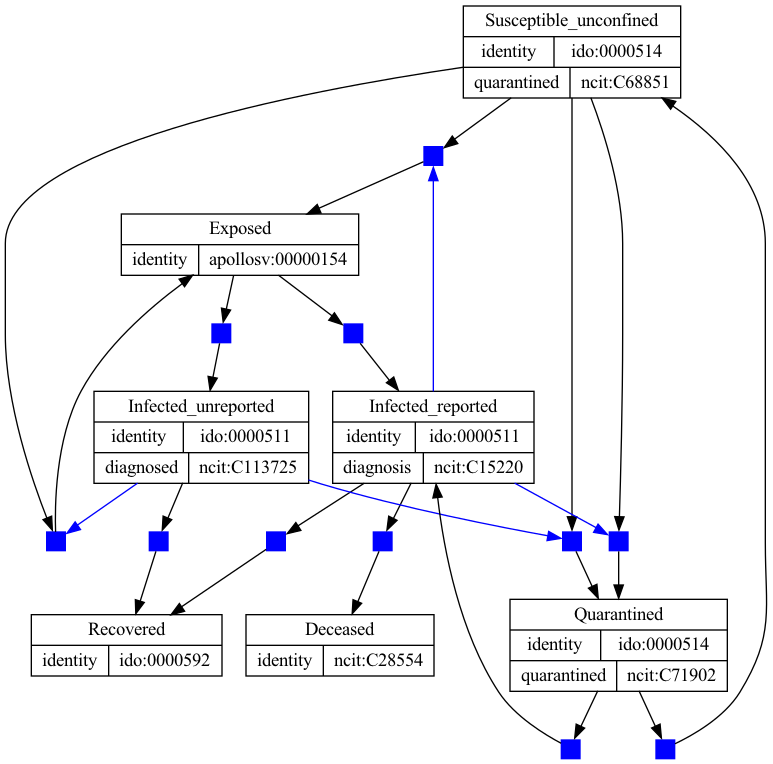

In [18]:
GraphicalModel.for_jupyter(model, width='50%')

In [19]:
model.observables = {
    'Cases': Observable(**cases.dict(), expression=Symbol('Infected_reported')),
    'Hospitalizations': Observable(**hospitalizations.dict(), expression=Symbol('h')*Symbol('Infected_reported')),
    'Deaths': Observable(**deaths.dict(), expression=Symbol('Deceased'))
}

In [20]:
param_reduce = ['m_t_phase_1', 'm_t_phase_2', 'm_t_phase_3', 'tau_1', 'tau_2', 'tau_3', 'tau_f', 'm_t',
                'a', 'b', 'p']

In [21]:
for p in param_reduce:
    model.eliminate_parameter(p)
for v in model.parameters.values():
    add_distribution(v)

In [22]:
model.parameters

{'f': Parameter(name='f', identifiers={}, context={}, value=0.2, distribution=Distribution(type='StandardUniform1', parameters={'minimum': 0.16, 'maximum': 0.24000000000000002})),
 'n': Parameter(name='n', identifiers={}, context={}, value=0.5, distribution=Distribution(type='StandardUniform1', parameters={'minimum': 0.4, 'maximum': 0.6})),
 'q': Parameter(name='q', identifiers={}, context={}, value=0.83, distribution=Distribution(type='StandardUniform1', parameters={'minimum': 0.6639999999999999, 'maximum': 0.996})),
 'sigma': Parameter(name='sigma', identifiers={}, context={}, value=0.2, distribution=Distribution(type='StandardUniform1', parameters={'minimum': 0.16, 'maximum': 0.24000000000000002})),
 'beta': Parameter(name='beta', identifiers={}, context={}, value=2.115e-08, distribution=Distribution(type='StandardUniform1', parameters={'minimum': 1.6920000000000002e-08, 'maximum': 2.538e-08})),
 'mu': Parameter(name='mu', identifiers={}, context={}, value=0.2, distribution=Distribu

In [23]:
model_to_json_file(model, 'BIOMD0000000983_template_model.json')
m = Model(model)

In [24]:
pm = PetriNetModel(m)

In [25]:
pm.to_json()

{'S': [{'sname': 'Susceptible_unconfined',
   'sprop': {'is_observable': False,
    'mira_ids': "[('identity', 'ido:0000514')]",
    'mira_context': "[('quarantined', 'ncit:C68851')]",
    'mira_concept': '{"name": "Susceptible_unconfined", "identifiers": {"ido": "0000514"}, "context": {"quarantined": "ncit:C68851"}}'},
   'concentration': 66990000.0},
  {'sname': 'Exposed',
   'sprop': {'is_observable': False,
    'mira_ids': "[('identity', 'apollosv:00000154')]",
    'mira_context': '[]',
    'mira_concept': '{"name": "Exposed", "identifiers": {"apollosv": "00000154"}, "context": {}}'},
   'concentration': 112.0},
  {'sname': 'Infected_reported',
   'sprop': {'is_observable': False,
    'mira_ids': "[('identity', 'ido:0000511')]",
    'mira_context': "[('diagnosis', 'ncit:C15220')]",
    'mira_concept': '{"name": "Infected_reported", "identifiers": {"ido": "0000511"}, "context": {"diagnosis": "ncit:C15220"}}'},
   'concentration': 12.0},
  {'sname': 'Infected_unreported',
   'sprop':

In [26]:
hospitalizations.dict()

{'name': 'Hospitalizations',
 'identifiers': {'ido': '0000511'},
 'context': {'hospitalization': 'ncit:C25179'}}

In [27]:
pm.to_json_file('BIOMD0000000983_miranet.json', indent=1)

## Giordano et al (SIDARTHE) model

In [28]:
model = copy.deepcopy(models['BIOMD0000000955'])
model = simplify_rate_laws(model)

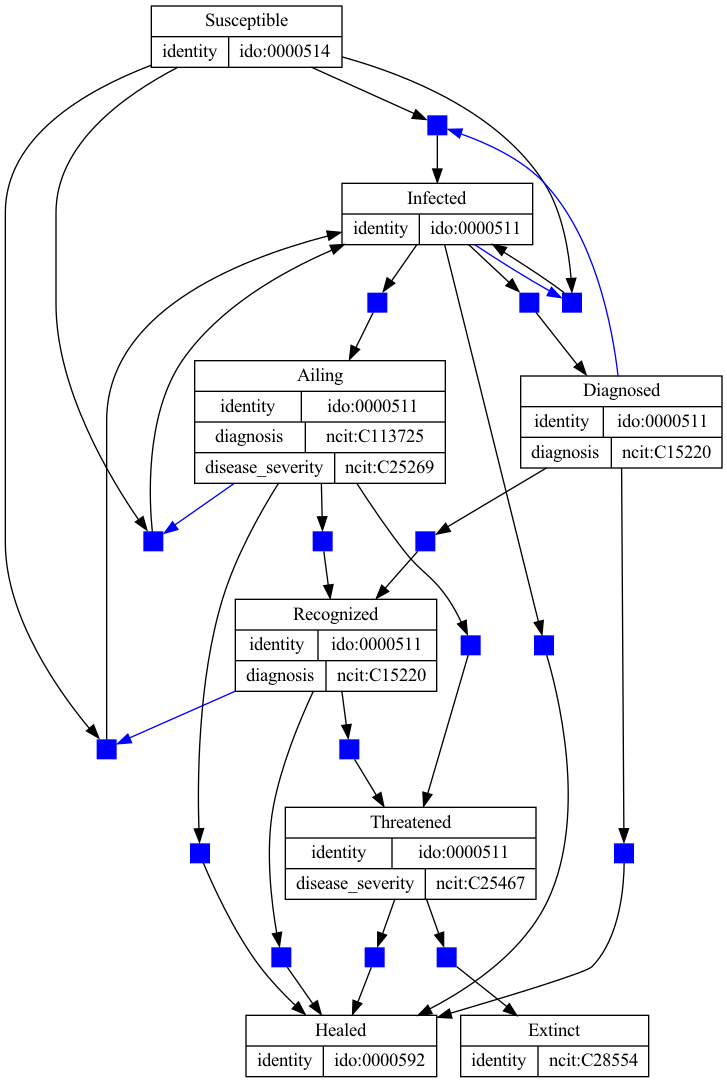

In [29]:
GraphicalModel.for_jupyter(model, width='50%')

In [30]:
param_reduce = ['Event_trigger_Fig3b', 'Event_trigger_Fig3d', 'Event_trigger_Fig4b', 'Event_trigger_Fig4d',
                'ModelValue_16', 'ModelValue_17', 'ModelValue_18', 'ModelValue_19', 'ModelValue_20', 'ModelValue_21',
                'Italy']

In [31]:
for p in param_reduce:
    model.substitute_parameter(p)
for v in model.parameters.values():
    add_distribution(v)

In [32]:
model.parameters

{'alpha': Parameter(name='alpha', identifiers={}, context={}, value=0.57, distribution=Distribution(type='StandardUniform1', parameters={'minimum': 0.45599999999999996, 'maximum': 0.6839999999999999})),
 'beta': Parameter(name='beta', identifiers={}, context={}, value=0.011, distribution=Distribution(type='StandardUniform1', parameters={'minimum': 0.008799999999999999, 'maximum': 0.0132})),
 'gamma': Parameter(name='gamma', identifiers={}, context={}, value=0.456, distribution=Distribution(type='StandardUniform1', parameters={'minimum': 0.3648, 'maximum': 0.5472})),
 'delta': Parameter(name='delta', identifiers={}, context={}, value=0.011, distribution=Distribution(type='StandardUniform1', parameters={'minimum': 0.008799999999999999, 'maximum': 0.0132})),
 'epsilon': Parameter(name='epsilon', identifiers={}, context={}, value=0.171, distribution=Distribution(type='StandardUniform1', parameters={'minimum': 0.1368, 'maximum': 0.20520000000000002})),
 'theta': Parameter(name='theta', iden

In [33]:
model.observables = {
    'Cases': Observable(**cases.dict(), expression=Symbol('Diagnosed')+Symbol('Recognized')+Symbol('Threatened')),
    'Hospitalizations': Observable(**hospitalizations.dict(), expression=Symbol('Recognized')+Symbol('Threatened')),
    'Deaths': Observable(**deaths.dict(), expression=Symbol('Extinct'))
}

In [34]:
tem
pm = PetriNetModel(Model(model))
pm.to_json_file('BIOMD0000000955_miranet.json', indent=1)

## Paiva et al model

In [35]:
model = copy.deepcopy(models['BIOMD0000000960'])
model = simplify_rate_laws(model)

In [36]:
param_reduce = [p for p in model.parameters
                if any(c in p for c in {'China', 'Italy', 'Spain', 'France', 'Germany'})]
for p in param_reduce:
    model.eliminate_parameter(p)

In [37]:
param_reduce = [p for p in model.parameters if 'ModelValue' in p
                and p not in {'ModelValue_5', 'ModelValue_123', 'ModelValue_124', 'ModelValue_125',
                              'ModelValue_26', 'ModelValue_119', 'ModelValue_120', 'ModelValue_121',
                              'ModelValue_117', 'ModelValue_17', 'ModelValue_122',
                              'ModelValue_13', 'ModelValue_118',
                              'ModelValue_127', 'ModelValue_135', 'ModelValue_18'}]
for p in param_reduce:
    model.substitute_parameter(p)
for v in model.parameters.values():
    add_distribution(v)

In [38]:
model.parameters

{'_6_Trigger_USA': Parameter(name='_6_Trigger_USA', identifiers={}, context={}, value=0.0, distribution=None),
 'beta_1': Parameter(name='beta_1', identifiers={}, context={}, value=0.334, distribution=Distribution(type='StandardUniform1', parameters={'minimum': 0.2672, 'maximum': 0.40080000000000005})),
 'l_1': Parameter(name='l_1', identifiers={}, context={}, value=0.673, distribution=Distribution(type='StandardUniform1', parameters={'minimum': 0.5384, 'maximum': 0.8076000000000001})),
 'l_a_1': Parameter(name='l_a_1', identifiers={}, context={}, value=8.0, distribution=Distribution(type='StandardUniform1', parameters={'minimum': 6.4, 'maximum': 9.6})),
 'kappa': Parameter(name='kappa', identifiers={}, context={}, value=0.44, distribution=Distribution(type='StandardUniform1', parameters={'minimum': 0.352, 'maximum': 0.528})),
 'rho': Parameter(name='rho', identifiers={}, context={}, value=0.053, distribution=Distribution(type='StandardUniform1', parameters={'minimum': 0.0424, 'maximum

In [39]:
len(model.templates)

12

In [40]:
model.templates

[ControlledConversion(rate_law=Infectious*ModelValue_5*Susceptible*beta_1_USA/(ModelValue_135*ModelValue_5 + 11000000.0), type='ControlledConversion', controller=Concept(name='Infectious', identifiers={'ido': '0000511'}, context={'disease_severity': 'ncit:C25269', 'hospitalization': 'ncit:C68851'}), subject=Concept(name='Susceptible', identifiers={'ido': '0000514'}, context={}), outcome=Concept(name='Exposed', identifiers={'apollosv': '00000154'}, context={}), provenance=[]),
 ControlledConversion(rate_law=Asymptomatic*ModelValue_5**2*Susceptible*beta_1_USA*l_a_1_USA/(ModelValue_135*ModelValue_5 + 11000000.0), type='ControlledConversion', controller=Concept(name='Asymptomatic', identifiers={'ido': '0000511'}, context={'disease_severity': 'ncit:C3833', 'hospitalization': 'ncit:C68851'}), subject=Concept(name='Susceptible', identifiers={'ido': '0000514'}, context={}), outcome=Concept(name='Exposed', identifiers={'apollosv': '00000154'}, context={}), provenance=[]),
 ControlledConversion(

In [41]:
model.observables = {
    'Cases': Observable(**cases.dict(), expression=Symbol('Infectious')),
    'Hospitalizations': Observable(**hospitalizations.dict(), expression=Symbol('Hospitalized')),
    'Deaths': Observable(**deaths.dict(), expression=Symbol('Deceased'))
}

In [42]:
pm = PetriNetModel(Model(model))
pm.to_json_file('BIOMD0000000960_miranet.json', indent=1)

In [43]:
model.parameters

{'_6_Trigger_USA': Parameter(name='_6_Trigger_USA', identifiers={}, context={}, value=0.0, distribution=None),
 'beta_1': Parameter(name='beta_1', identifiers={}, context={}, value=0.334, distribution=Distribution(type='StandardUniform1', parameters={'minimum': 0.2672, 'maximum': 0.40080000000000005})),
 'l_1': Parameter(name='l_1', identifiers={}, context={}, value=0.673, distribution=Distribution(type='StandardUniform1', parameters={'minimum': 0.5384, 'maximum': 0.8076000000000001})),
 'l_a_1': Parameter(name='l_a_1', identifiers={}, context={}, value=8.0, distribution=Distribution(type='StandardUniform1', parameters={'minimum': 6.4, 'maximum': 9.6})),
 'kappa': Parameter(name='kappa', identifiers={}, context={}, value=0.44, distribution=Distribution(type='StandardUniform1', parameters={'minimum': 0.352, 'maximum': 0.528})),
 'rho': Parameter(name='rho', identifiers={}, context={}, value=0.053, distribution=Distribution(type='StandardUniform1', parameters={'minimum': 0.0424, 'maximum